# baseline: GRL method

# Preprocessing data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy.io as sio
import time

import os
from sklearn.model_selection import train_test_split
# Tensorflow or PyTorch?
import tensorflow as tf
from tensorflow import keras

In [2]:
tf.config.experimental.list_physical_devices('GPU')

[]

In [3]:
# MNIST Dataset
(mnist_X_train, mnist_y_train), (mnist_X_test, mnist_y_test) = keras.datasets.mnist.load_data()

mnist_X_train.shape, mnist_y_train.shape, mnist_X_test.shape, mnist_y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [4]:
mnist_X_train = mnist_X_train.astype('float32')
mnist_X_test = mnist_X_test.astype('float32')
mnist_X_train.dtype

dtype('float32')

In [5]:
# USPS Dataset
with h5py.File('usps.h5', 'r') as hf:
    train = hf.get('train')
    usps_X_train = np.reshape(train.get('data')[:], (-1,16,16))
    usps_y_train = train.get('target')[:]
    test = hf.get('test')
    usps_X_test = np.reshape(test.get('data')[:], (-1,16,16))
    usps_y_test = test.get('target')[:]

usps_X_train.shape, usps_y_train.shape, usps_X_test.shape, usps_y_test.shape

((7291, 16, 16), (7291,), (2007, 16, 16), (2007,))

In [6]:
usps_X_train = usps_X_train.astype('float32')
usps_X_test = usps_X_test.astype('float32')
usps_X_train.dtype

dtype('float32')

In [7]:
# SVHN Dataset
f = sio.loadmat('train_32x32.mat')
svhn_X_train = np.moveaxis(np.array(f['X']), -1, 0)
svhn_y_train = np.array(f['y']).squeeze()
f = sio.loadmat('test_32x32.mat')
svhn_X_test = np.moveaxis(np.array(f['X']), -1, 0)
svhn_y_test = np.array(f['y']).squeeze()

svhn_X_train.shape, svhn_y_train.shape, svhn_X_test.shape, svhn_y_test.shape

((73257, 32, 32, 3), (73257,), (26032, 32, 32, 3), (26032,))

In [8]:
svhn_X_train = svhn_X_train.astype('float32')
svhn_X_test = svhn_X_test.astype('float32')
svhn_X_train.dtype

dtype('float32')

In [9]:
svhn_y_train[svhn_y_train==10]=0
svhn_y_test[svhn_y_test==10]=0

In [10]:
def plot_digits(X, y=None, grid=None):
    if (X.ndim==2):
        fig, ax = plt.subplots()
        ax.imshow(X, cmap='gray')
        ax.axis('off')
        if (y is not None):
            ax.set_title('Label ' + str(y))
        plt.show()
    else:
        if (grid is None):
            fig, ax = plt.subplots(X.shape[0])
        else:
            fig, ax = plt.subplots(grid[0], grid[1])
        for i in range(X.shape[0]):
            ax.flatten()[i].imshow(X[i], cmap='gray')
            ax.flatten()[i].axis('off')
            if (y is not None):
                ax.flatten()[i].set_title('Label ' + str(y[i]))
        plt.show()
        
def plot_color_digits(X, y=None, grid=None):
    if (X.ndim==3):
        fig, ax = plt.subplots()
        ax.imshow(X)
        ax.axis('off')
        if (y is not None):
            ax.set_title('Label ' + str(y))
        plt.show()
    else:
        if (grid is None):
            fig, ax = plt.subplots(X.shape[0])
        else:
            fig, ax = plt.subplots(grid[0], grid[1])
        for i in range(X.shape[0]):
            ax.flatten()[i].imshow(X[i])
            ax.flatten()[i].axis('off')
            if (y is not None):
                ax.flatten()[i].set_title('Label ' + str(y[i]))
        plt.show()

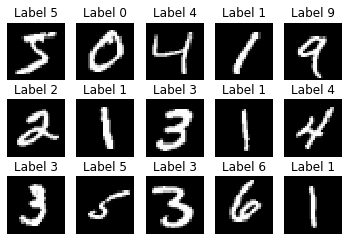

In [11]:
plot_digits(mnist_X_train[:15],mnist_y_train[:15],(3,5))

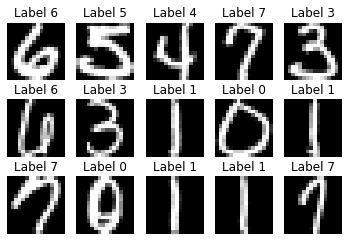

In [12]:
plot_digits(usps_X_train[:15],usps_y_train[:15],(3,5))

In [13]:
mnist_0_4 = np.nonzero(mnist_y_train < 5)[0]
mnist_5_9 = np.nonzero(mnist_y_train >= 5)[0]
usps_0_4 = np.nonzero(usps_y_train < 5)[0]
usps_5_9 = np.nonzero(usps_y_train >= 5)[0]
svhn_0_4 = np.nonzero(svhn_y_train < 5)[0]
svhn_5_9 = np.nonzero(svhn_y_train >= 5)[0]

In [14]:
#same apply to test
mnist_0_4t = np.nonzero(mnist_y_test < 5)[0]
mnist_5_9t = np.nonzero(mnist_y_test >= 5)[0]
usps_0_4t = np.nonzero(usps_y_test < 5)[0]
usps_5_9t = np.nonzero(usps_y_test >= 5)[0]
svhn_0_4t = np.nonzero(svhn_y_test < 5)[0]
svhn_5_9t = np.nonzero(svhn_y_test >= 5)[0]

image resize

In [15]:
mnist_X_train = mnist_X_train[:, :, :, np.newaxis]
mnist_X_train = tf.broadcast_to(mnist_X_train, mnist_X_train.shape[:-1] + (3,))
mnist_X_train = tf.image.resize(mnist_X_train, (32,32))
usps_X_train = usps_X_train[:, :, :, np.newaxis]
usps_X_train = tf.broadcast_to(usps_X_train, usps_X_train.shape[:-1] + (3,))
usps_X_train = tf.image.resize(usps_X_train, (32,32))
svhn_X_train = tf.cast(tf.convert_to_tensor(svhn_X_train),'float32')

In [16]:
#same apply  test
mnist_X_test = mnist_X_test[:, :, :, np.newaxis]
mnist_X_test = tf.broadcast_to(mnist_X_test, mnist_X_test.shape[:-1] + (3,))
mnist_X_test = tf.image.resize(mnist_X_test, (32,32))
usps_X_test = usps_X_test[:, :, :, np.newaxis]
usps_X_test = tf.broadcast_to(usps_X_test, usps_X_test.shape[:-1] + (3,))
usps_X_test = tf.image.resize(usps_X_test, (32,32))
svhn_X_test = tf.cast(tf.convert_to_tensor(svhn_X_test),'float32')

data scaling

In [17]:
mnist_X_train = mnist_X_train / 255.0
svhn_X_train = svhn_X_train / 255.0
tf.math.reduce_min(mnist_X_train), tf.math.reduce_max(mnist_X_train)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0>)

In [18]:
tf.math.reduce_min(svhn_X_train), tf.math.reduce_max(svhn_X_train)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0>)

In [19]:
#same apply to test
mnist_X_test = mnist_X_test / 255.0
svhn_X_test = svhn_X_test / 255.0
tf.math.reduce_min(mnist_X_test), tf.math.reduce_max(mnist_X_test)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0>)

In [20]:
tf.math.reduce_min(svhn_X_test), tf.math.reduce_max(svhn_X_test)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0>)

Normalization (disabled)

In [21]:
mnist_train_mean = np.mean(mnist_X_train,)
mnist_train_std  = np.std(mnist_X_train)

In [22]:
mnist_train_mean, mnist_train_std

(0.13085152, 0.28923184)

In [23]:
usps_train_mean = np.mean(usps_X_train)
usps_train_std  = np.std(usps_X_train)

In [24]:
usps_train_mean, usps_train_std

(0.2544808, 0.3481659)

# General Component

fe network

In [21]:
def FeatureEncoder(name=None):
    '''
    Return a Feature Encoder.
    '''
    fe_input = keras.Input(shape=(32,32,3))
    x = keras.layers.Dropout(0.2)(fe_input)
    x = keras.layers.Conv2D(filters=64, kernel_size=5, strides=1,
                                   padding='valid', activation='relu')(x)
    x = keras.layers.MaxPooling2D(2, strides=2)(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Conv2D(filters=64, kernel_size=5, strides=1,
                                   padding='valid', activation='relu')(x)
    x = keras.layers.MaxPooling2D(2, strides=2)(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Conv2D(filters=128, kernel_size=5, strides=1,
                                   padding='valid', activation='relu')(x)
    fe_out = keras.layers.Flatten()(x)
    if (name is None):
        fe = keras.Model(inputs=fe_input, outputs=fe_out, name='FeatureExtractor')
    else:
        fe = keras.Model(inputs=fe_input, outputs=fe_out, name=name)
    return fe

In [22]:
fe_demo = FeatureEncoder()
fe_demo.summary()

Model: "FeatureExtractor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)     

classcification

In [23]:
def ClassificationNet(name=None):
    '''
    Return a Classification Network.
    Input: None.
    Output: A tuple containing the handle of input layer and output layer.
    '''
    cl_input = keras.Input(shape=[128])
    x = keras.layers.Dense(128, activation='relu')(cl_input)
    cl_out = keras.layers.Dense(5, activation='relu')(x)
    if (name is None):
        cl = keras.Model(inputs=cl_input, outputs=cl_out, name='ClassificationNetwork')
    else:
        cl = keras.Model(inputs=cl_input, outputs=cl_out, name=name)
    return cl

In [24]:
cl_demo = ClassificationNet()
cl_demo.summary()

Model: "ClassificationNetwork"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 17,157
Trainable params: 17,157
Non-trainable params: 0
_________________________________________________________________


# GRL Additional Component

Flip Gradient Builder:
The gradient reversal layer has no parameters as-sociated with it (apart from the meta-parameter λ, which is not updated by backpropagation). During the forward propagation, GRL acts as an identity transform. During the backpropagation though, GRL takes the gradient from the subsequent level, multiplies it by −λ and passes it to
the preceding layer.

In [25]:
def flip_gradient(x, l=1.0):
    positive_path = tf.stop_gradient(x * tf.cast(1 + l, tf.float32))
    negative_path = -x * tf.cast(l, tf.float32)
    return positive_path + negative_path

Domain prediction:

In [26]:
def DomainNet(name=None):
    '''
    Return a Domain Classification Network.
    Input: None.
    Output: A tuple containing the handle of input layer and output layer.
    '''
    dl_input = keras.Input(shape=[128])
    x = keras.layers.Dense(128, activation='relu')(dl_input)
    '''source/target, output shape = 2'''
    dl_out = keras.layers.Dense(2, activation='relu')(x)
    if (name is None):
        dl = keras.Model(inputs=dl_input, outputs=dl_out, name='DomainClassificationNetwork')
    else:
        dl = keras.Model(inputs=dl_input, outputs=dl_out, name=name)
    return dl

In [27]:
dl_demo = DomainNet()
dl_demo.summary()

Model: "DomainClassificationNetwork"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 16,770
Trainable params: 16,770
Non-trainable params: 0
_________________________________________________________________


# GRL Model

Wiring up the component:

In [28]:
# Input layer
grl_input_src = keras.Input(shape=(32,32,3), name="SourceInput")
grl_input_tgt = keras.Input(shape=(32,32,3), name="TargetInput")
"no source input skip"

# Fed to the same feature extractor
grl_fe = FeatureEncoder()
grl_fe_src = grl_fe(grl_input_src)
grl_fe_tgt = grl_fe(grl_input_tgt)

# Source representation flows to the classification network
grl_out_cl = ClassificationNet()(grl_fe_src)

# Flip the gradient when backpropagating through this operation
grl_fe_src_feat = flip_gradient(grl_fe_src,1.0)#!!uncertain about self.l
grl_fe_tgt_feat = flip_gradient(grl_fe_tgt,1.0)

# Domain prediction
grl_dc = DomainNet()
grl_out_d_src = grl_dc(grl_fe_src_feat)
grl_out_d_tgt = grl_dc(grl_fe_tgt_feat)

# Final model
mod_grl = keras.Model(
    inputs=[grl_input_src, grl_input_tgt],
    outputs=[grl_out_cl,   # Categorical Classifier
             grl_out_d_src, # Sourve Domain Predictor
             grl_out_d_tgt] # Target Domain Preductor
)



In [29]:
mod_grl.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
SourceInput (InputLayer)        [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
TargetInput (InputLayer)        [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
FeatureExtractor (Functional)   (None, 128)          312256      SourceInput[0][0]                
                                                                 TargetInput[0][0]                
__________________________________________________________________________________________________
tf.math.multiply (TFOpLambda)   (None, 128)          0           FeatureExtractor[0][0]       

# Build the model:

In [30]:
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return tf.gather(X, idx), tf.gather(y, idx)

In [31]:
def print_status_bar(iteration, total, loss=None):
    if (loss is not None):
        metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                             for m in loss])
    else:
        metrics = 'No loss available'
    end = "" if iteration < total else "\n"
    print("\r{}/{} - ".format(iteration, total) + metrics,
          end=end)

X_src = tf.gather(mnist_X_train, mnist_0_4)
y_src = tf.gather(mnist_y_train, mnist_0_4)
X_tgt = tf.gather(usps_X_train, usps_0_4)
y_tgt = tf.gather(usps_y_train, usps_0_4)
batch_size = 64
n_samples = max(len(X_src), len(X_tgt))
n_steps = n_samples // batch_size
src_size = batch_size
tgt_size = batch_size
X_src_batch, y_src_batch = random_batch(X_src, y_src, src_size)
X_tgt_batch, y_tgt_batch = random_batch(X_tgt, y_tgt, tgt_size)

outputs = mod_grl((X_src_batch, X_tgt_batch), training=True)
print(outputs[0])

In [32]:
def train_grl_model(model, X_src, y_src, X_tgt, y_tgt, optimizers, batch_size=64, name=None):
    # Get the sample size, number of steps, source size, and target size
    
    n_samples = max(len(X_src), len(X_tgt))
    n_steps = n_samples // batch_size
    src_size = batch_size
    tgt_size = batch_size

    # Define loss functions
    layers = model.layers
    cat_loss = keras.losses.CategoricalCrossentropy()
    bin_loss = keras.losses.BinaryCrossentropy()
    
    
    # Define loss metrics and the history tracker
    loss_name = ['loss_ce','loss_domain','loss_f_total']
    mean_loss = []
    for l in loss_name:
        mean_loss.append(keras.metrics.Mean(name=l))
    history = [loss_name]
    
    for step in range(1, n_steps + 1):
        # Sample a batch from source and target data
        X_src_batch, y_src_batch = random_batch(X_src, y_src, src_size)
        X_tgt_batch, y_tgt_batch = random_batch(X_tgt, y_tgt, tgt_size)
        with tf.GradientTape(persistent=True) as tape:
            # Feed-forward Network
            outputs = model((X_src_batch, X_tgt_batch), training=True)
            # Separate the outputs
            out_c1 = outputs[0]
            d_src = outputs[1]
            d_tgt = outputs[2]
            #out_c1, d_src, d_tgt = outputs
            
            #Calculate the losses
            loss_ce = cat_loss(tf.one_hot(y_src_batch,5), keras.activations.softmax(out_c1))
            loss_domain = (bin_loss(tf.constant([[1.]] * src_size), d_src) +
                           bin_loss(tf.constant([[1.]] * tgt_size), d_tgt))
            loss_f_total = loss_ce + loss_domain
        
        gradient_fe = tape.gradient(loss_f_total,
                model.get_layer('FeatureExtractor').trainable_variables)
        optimizers[0].apply_gradients(zip(gradient_fe,
                model.get_layer('FeatureExtractor').trainable_variables))
        gradient_ce = tape.gradient(loss_ce,
                model.get_layer('ClassificationNetwork').trainable_variables)
        optimizers[1].apply_gradients(zip(gradient_ce,
                model.get_layer('ClassificationNetwork').trainable_variables))
        gradient_domain = tape.gradient(loss_domain,
                model.get_layer('DomainClassificationNetwork').trainable_variables)
        optimizers[2].apply_gradients(zip(gradient_domain,
                model.get_layer('DomainClassificationNetwork').trainable_variables))
           
           
        mean_loss[0](loss_ce)
        mean_loss[1](loss_domain)
        mean_loss[2](loss_f_total)
            
        # Print Status Bar
        print_status_bar(step * batch_size, n_samples, mean_loss)

        # Save the history
        history.append([m.result() for m in mean_loss])
            
        # Delete the tape
        del(tape)
    print_status_bar(n_samples, n_samples, mean_loss)
    return history

# Output of the model

In [33]:
def model_output(model, X_src_batch, X_tgt_batch):
    src_size = len(X_src_batch)
    tgt_size = len(X_tgt_batch)


    # Feed-forward Network
    outputs = model((X_src_batch, X_tgt_batch))
    
    # Separate the outputs
    out_c1, d_src, d_tgt = outputs
    return out_c1, d_src, d_tgt
   

# Novelty detection

In [34]:
def novelty_detector(model, X, c_softmax=1.0, c_gloss=1.0, c_dscore=1.0):
    '''
    A novelty detector based on proposed method. Output a score based on maximum softmax probability,
    generator loss, and discriminator score.
    '''
    batch_size = 64
    n_batch = len(X) // batch_size
    softmax_score = np.array([]).reshape(0)
    
    
    for i in range(n_batch):
        s = i * batch_size
        e = (i+1) * batch_size
        outputs = mod_grl((X[s:e], X[s:e]))
        out_c1, d_src, d_tgt= outputs
        
        softmax_score = np.concatenate((softmax_score,
            tf.math.reduce_max(tf.nn.softmax(out_c1),
                               axis=1)))
        
        
        print_status_bar(i * batch_size, len(X))
    
    s = n_batch * batch_size
    e = len(X)
    outputs = mod_grl((X[s:e], X[s:e]))
    out_c1, d_src, d_tgt= outputs

    softmax_score = np.concatenate((softmax_score,
        tf.math.reduce_max(tf.nn.softmax(out_c1),
                           axis=1)))
    
    
    print_status_bar(len(X), len(X))
    
    return softmax_score

In [35]:
from sklearn.metrics import roc_curve, auc
def plot_auc_curve(fpr, tpr, ax):
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color='darkorange',
             lw=2.0, label='ROC curve (area = %0.3f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='gray', lw=1.0, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")

# minst -> usps

In [40]:
opt1 = []
for i in range(3):
    opt1.append(keras.optimizers.Adam(learning_rate=0.0001))
history1 = train_grl_model(mod_grl, X_src = tf.gather(mnist_X_train, mnist_0_4),
                          y_src = tf.gather(mnist_y_train, mnist_0_4),
                          X_tgt = tf.gather(usps_X_train, usps_0_4),
                          y_tgt = tf.gather(usps_y_train, usps_0_4),
                          optimizers = opt1, batch_size=64, name='mnist_usps')

30596/30596 - loss_ce: 1.0058 - loss_domain: 30.8264 - loss_f_total: 31.8322


In [43]:
#novelty detector on target train
X_origin = tf.gather(usps_X_train, usps_0_4)
X_novel = tf.gather(usps_X_train, usps_5_9)
len_origin = len(X_origin)
len_novel = len(X_novel)
X_tgt = tf.concat((X_origin, X_novel), axis=0)
y_tgt1 = tf.constant([[0.]] * len_origin + [[1.]] * len_novel)
minst_usps = novelty_detector(mod_grl, X_tgt)

7291/7291 - No loss available


In [41]:
minst_usps

array([0.53849334, 0.82252914, 0.81767827, ..., 0.5379318 , 0.89938325,
       0.37323835])

Text(0.5, 1.0, 'MNIST to USPS softmax training')

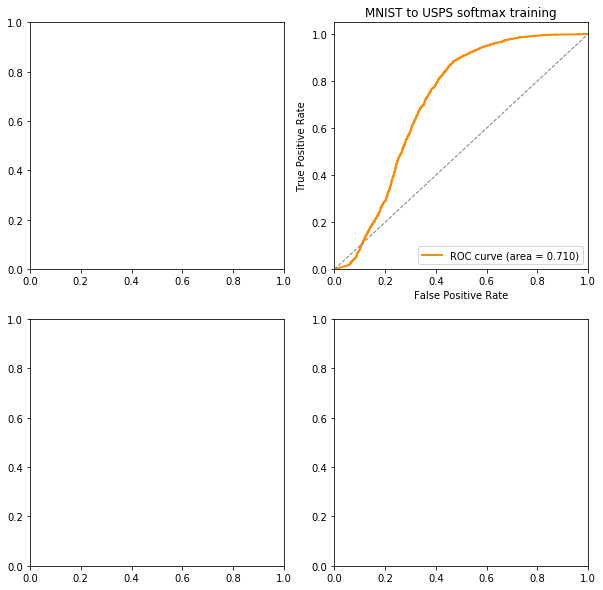

In [44]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
fpr, tpr, _ = roc_curve(y_tgt1, -minst_usps)
plot_auc_curve(fpr, tpr, ax[0,1])
ax[0,1].set_title('MNIST to USPS softmax training')

analyze the output

In [41]:
index = np.random.randint(0, min(len(mnist_0_4), len(usps_0_4)), 10)
X_src, X_tgt = (tf.gather(mnist_X_train, mnist_0_4[index]), 
                tf.gather(usps_X_train, usps_0_4[index]))
y_src, y_tgt = (tf.gather(mnist_y_train, mnist_0_4[index]),
                tf.gather(usps_y_train, usps_0_4[index]))
(out_c1, d_src, d_tgt) = model_output(mod_grl, X_src, X_tgt)

In [42]:
tf.nn.softmax(out_c1), tf.math.argmax(out_c1,axis=1), y_src

(<tf.Tensor: shape=(10, 5), dtype=float32, numpy=
 array([[0.00671557, 0.00671557, 0.9713381 , 0.0085151 , 0.00671557],
        [0.00258955, 0.9864811 , 0.00360142, 0.00473852, 0.00258955],
        [0.2       , 0.2       , 0.2       , 0.2       , 0.2       ],
        [0.00439895, 0.00439895, 0.981065  , 0.00573812, 0.00439895],
        [0.00672896, 0.00672896, 0.963469  , 0.01634398, 0.00672896],
        [0.9878318 , 0.00187918, 0.00364771, 0.00476212, 0.00187918],
        [0.00605653, 0.00605653, 0.9709708 , 0.01085953, 0.00605653],
        [0.00277549, 0.97779036, 0.00806361, 0.00859511, 0.00277549],
        [0.01590988, 0.92582715, 0.01780544, 0.02454767, 0.01590988],
        [0.00228659, 0.00228659, 0.99085367, 0.00228659, 0.00228659]],
       dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=int64, numpy=array([2, 1, 0, 2, 2, 0, 2, 1, 1, 2])>,
 <tf.Tensor: shape=(10,), dtype=uint8, numpy=array([2, 1, 4, 2, 2, 0, 2, 1, 1, 2], dtype=uint8)>)

In [47]:
tf.nn.softmax(d_src)

<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
array([[0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5]], dtype=float32)>

In [48]:
tf.nn.softmax(d_tgt)

<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
array([[0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5]], dtype=float32)>

# svhn-> mnist

In [ ]:
opt2 = []
for i in range(3):
    opt2.append(keras.optimizers.Adam(learning_rate=0.0001))

history2 = train_grl_model(mod_grl, X_src = tf.gather(svhn_X_train, svhn_0_4),
                           y_src = tf.gather(svhn_y_train, svhn_0_4),
                           X_tgt = tf.gather(mnist_X_train, mnist_0_4),
                           y_tgt = tf.gather(mnist_y_train, mnist_0_4),
                           optimizers = opt2, batch_size=64, name='svhn_mnist')

In [50]:
#novelty detector on target train
X_origin = tf.gather(mnist_X_train, mnist_0_4)
X_novel = tf.gather(mnist_X_train, mnist_5_9)
len_origin = len(X_origin)
len_novel = len(X_novel)
X_tgt = tf.concat((X_origin, X_novel), axis=0)
y_tgt2 = tf.constant([[0.]] * len_origin + [[1.]] * len_novel)
svhn_mnist = novelty_detector(mod_grl, X_tgt)

60000/60000 - No loss available


In [44]:
svhn_mnist

array([0.85521036, 0.2       , 0.48891205, ..., 0.92579478, 0.33247375,
       0.2       ])

Text(0.5, 1.0, 'SVHN to MNIST softmax training')

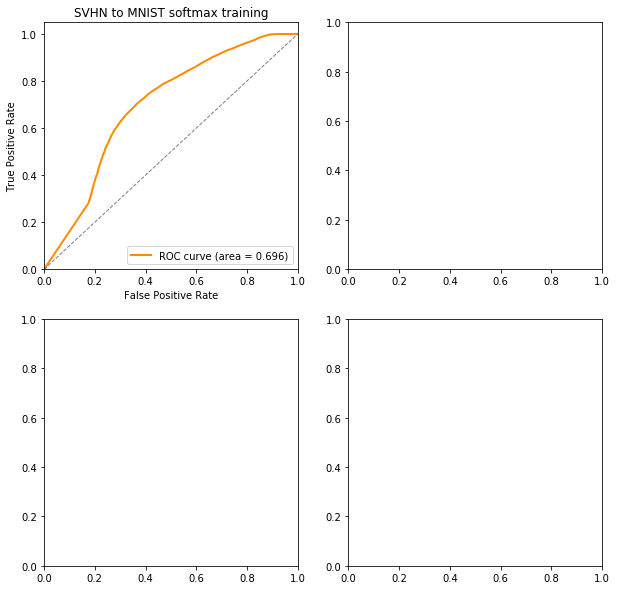

In [54]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
fpr, tpr, _ = roc_curve(y_tgt2, -svhn_mnist)
plot_auc_curve(fpr, tpr, ax[0,0])
ax[0,0].set_title('SVHN to MNIST softmax training')

In [95]:
index = np.random.randint(0, min(len(mnist_0_4), len(svhn_0_4)), 10)
X_src, X_tgt = (tf.gather(svhn_X_train, svhn_0_4[index]), 
                tf.gather(mnist_X_train, mnist_0_4[index]))
y_src, y_tgt = (tf.gather(svhn_y_train, svhn_0_4[index]),
                tf.gather(mnist_y_train, mnist_0_4[index]))
(out_c1, d_src, d_tgt) = model_output(mod_grl, X_src, X_tgt)

In [96]:
tf.nn.softmax(out_c1), tf.math.argmax(out_c1,axis=1), y_src

(<tf.Tensor: shape=(10, 5), dtype=float32, numpy=
 array([[0.1026991 , 0.1026991 , 0.50956744, 0.18233524, 0.1026991 ],
        [0.61124957, 0.09718759, 0.09718759, 0.09718759, 0.09718759],
        [0.1556008 , 0.1556008 , 0.35466397, 0.17853366, 0.1556008 ],
        [0.17178291, 0.07929365, 0.34636015, 0.32326967, 0.07929365],
        [0.10296802, 0.10296802, 0.16341671, 0.52767915, 0.10296802],
        [0.15060748, 0.1500132 , 0.16100071, 0.38836545, 0.1500132 ],
        [0.14557217, 0.12141923, 0.3604764 , 0.25111297, 0.12141923],
        [0.27849394, 0.10138561, 0.32432026, 0.19441456, 0.10138561],
        [0.08141018, 0.18769804, 0.26437938, 0.38510224, 0.08141018],
        [0.1450854 , 0.09100736, 0.531647  , 0.14125289, 0.09100736]],
       dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=int64, numpy=array([2, 0, 2, 2, 3, 3, 2, 2, 3, 2])>,
 <tf.Tensor: shape=(10,), dtype=uint8, numpy=array([2, 1, 2, 4, 1, 2, 2, 1, 1, 3], dtype=uint8)>)

# usps -> mnist

In [56]:
opt3 = []
for i in range(3):
    opt3.append(keras.optimizers.Adam(learning_rate=0.0001))
history3 = train_grl_model(mod_grl, X_src = tf.gather(usps_X_train, usps_0_4),
                          y_src = tf.gather(usps_y_train, usps_0_4),
                          X_tgt = tf.gather(mnist_X_train, mnist_0_4),
                          y_tgt = tf.gather(mnist_y_train, mnist_0_4),
                          optimizers = opt3, batch_size=64, name='usps_mnist')

30596/30596 - loss_ce: 0.3506 - loss_domain: 30.8472 - loss_f_total: 31.1979


In [57]:
#novelty detector on target train
X_origin = tf.gather(mnist_X_train, mnist_0_4)
X_novel = tf.gather(mnist_X_train, mnist_5_9)
len_origin = len(X_origin)
len_novel = len(X_novel)
X_tgt = tf.concat((X_origin, X_novel), axis=0)
y_tgt3 = tf.constant([[0.]] * len_origin + [[1.]] * len_novel)
usps_mnist = novelty_detector(mod_grl, X_tgt)

60000/60000 - No loss available


In [58]:
usps_mnist

array([0.9821732 , 0.2       , 0.33498764, ..., 0.58409703, 0.21139614,
       0.31521785])

Text(0.5, 1.0, 'USPS to MNIST softmax training')

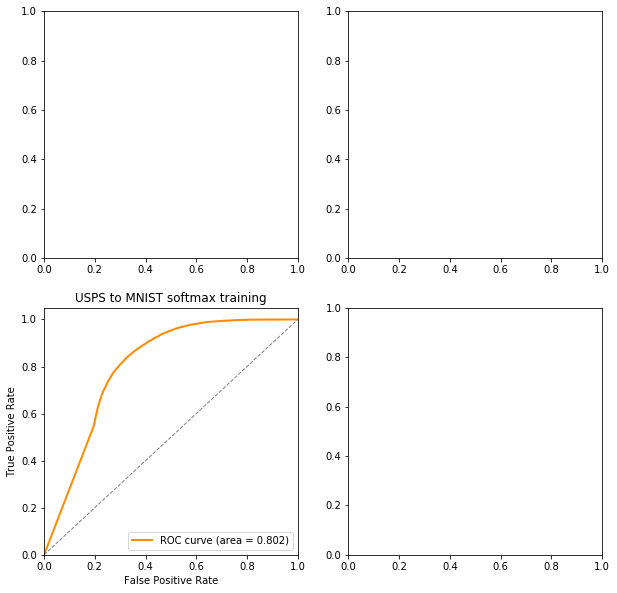

In [59]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
fpr, tpr, _ = roc_curve(y_tgt3, -usps_mnist)
plot_auc_curve(fpr, tpr, ax[1,0])
ax[1,0].set_title('USPS to MNIST softmax training')

In [93]:
index = np.random.randint(0, min(len(mnist_0_4), len(usps_0_4)), 10)
X_src, X_tgt = (tf.gather(usps_X_train, usps_0_4[index]), 
                tf.gather(mnist_X_train, mnist_0_4[index]))
y_src, y_tgt = (tf.gather(usps_y_train, usps_0_4[index]),
                tf.gather(mnist_y_train, mnist_0_4[index]))
(out_c1, d_src, d_tgt) = model_output(mod_grl, X_src, X_tgt)

In [94]:
tf.nn.softmax(out_c1), tf.math.argmax(out_c1,axis=1), y_src

(<tf.Tensor: shape=(10, 5), dtype=float32, numpy=
 array([[2.3387219e-01, 2.5036668e-02, 6.9101769e-01, 2.5036668e-02,
         2.5036668e-02],
        [3.2238462e-03, 5.8048185e-02, 8.9656651e-01, 3.9257325e-02,
         2.9041509e-03],
        [2.0000000e-01, 2.0000000e-01, 2.0000000e-01, 2.0000000e-01,
         2.0000000e-01],
        [1.8613079e-03, 9.9001300e-01, 1.8613079e-03, 4.4031637e-03,
         1.8613079e-03],
        [1.4305860e-03, 9.8097539e-01, 1.4305860e-03, 1.4733025e-02,
         1.4305860e-03],
        [9.9842775e-01, 2.0934579e-04, 6.9949968e-04, 4.5402272e-04,
         2.0934579e-04],
        [3.8971528e-02, 1.9520693e-01, 8.0318712e-02, 6.4653128e-01,
         3.8971528e-02],
        [3.4419954e-04, 9.9816293e-01, 3.4419954e-04, 8.0435659e-04,
         3.4419954e-04],
        [1.3076302e-03, 9.7588944e-01, 1.3076302e-03, 2.0187713e-02,
         1.3076302e-03],
        [3.5103393e-04, 9.9788493e-01, 3.5103393e-04, 1.0619862e-03,
         3.5103393e-04]], dtype=flo

# svhn -> usps

In [62]:
opt4 = []
for i in range(3):
    opt4.append(keras.optimizers.Adam(learning_rate=0.0001))
history4 = train_grl_model(mod_grl, X_src = tf.gather(svhn_X_train, svhn_0_4),
                          y_src = tf.gather(svhn_y_train, svhn_0_4),
                          X_tgt = tf.gather(usps_X_train, usps_0_4),
                          y_tgt = tf.gather(usps_y_train, usps_0_4),
                          optimizers = opt4, batch_size=64, name='svhn-usps')

45349/45349 - loss_ce: 1.5581 - loss_domain: 22.0301 - loss_f_total: 23.5883


In [63]:
#novelty detector on target train
X_origin = tf.gather(usps_X_train, usps_0_4)
X_novel = tf.gather(usps_X_train, usps_5_9)
len_origin = len(X_origin)
len_novel = len(X_novel)
X_tgt = tf.concat((X_origin, X_novel), axis=0)
y_tgt4 = tf.constant([[0.]] * len_origin + [[1.]] * len_novel)
svhn_usps = novelty_detector(mod_grl, X_tgt)

7291/7291 - No loss available


In [64]:
svhn_usps

array([0.24616422, 0.32070506, 0.35555738, ..., 0.325755  , 0.34897208,
       0.32482457])

Text(0.5, 1.0, 'SVHN to USPS softmax training')

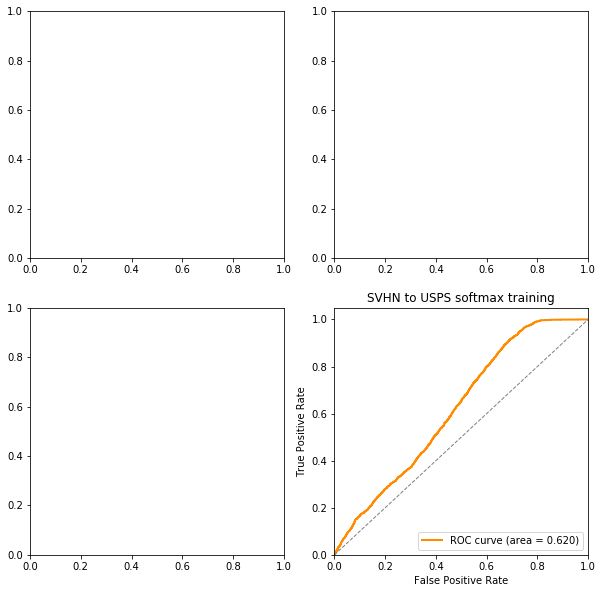

In [65]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
fpr, tpr, _ = roc_curve(y_tgt4, -svhn_usps)
plot_auc_curve(fpr, tpr, ax[1,1])
ax[1,1].set_title('SVHN to USPS softmax training')

In [91]:
index = np.random.randint(0, min(len(svhn_0_4), len(usps_0_4)), 10)
X_src, X_tgt = (tf.gather(svhn_X_train, svhn_0_4[index]), 
                tf.gather(usps_X_train, usps_0_4[index]))
y_src, y_tgt = (tf.gather(svhn_y_train, svhn_0_4[index]),
                tf.gather(usps_y_train, usps_0_4[index]))
(out_c1, d_src, d_tgt) = model_output(mod_grl, X_src, X_tgt)

In [92]:
tf.nn.softmax(out_c1), tf.math.argmax(out_c1,axis=1), y_src

(<tf.Tensor: shape=(10, 5), dtype=float32, numpy=
 array([[0.07544554, 0.07544554, 0.24768567, 0.52597773, 0.07544554],
        [0.09973572, 0.09973572, 0.24391536, 0.4568775 , 0.09973572],
        [0.08442004, 0.03331068, 0.5501029 , 0.29885572, 0.03331068],
        [0.1388375 , 0.1388375 , 0.31716198, 0.26632553, 0.1388375 ],
        [0.12625729, 0.12625729, 0.34797966, 0.2732485 , 0.12625729],
        [0.12553607, 0.09025401, 0.5686307 , 0.12532519, 0.09025401],
        [0.20735498, 0.19816124, 0.19816124, 0.19816124, 0.19816124],
        [0.17246413, 0.15099758, 0.29393315, 0.23160751, 0.15099758],
        [0.16536637, 0.15580906, 0.2742915 , 0.24872398, 0.15580906],
        [0.17034763, 0.09165979, 0.26179352, 0.3845393 , 0.09165978]],
       dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 3, 2, 2, 2, 2, 0, 2, 2, 3])>,
 <tf.Tensor: shape=(10,), dtype=uint8, numpy=array([1, 3, 2, 4, 2, 3, 0, 1, 0, 4], dtype=uint8)>)

4 plots together

Text(0.5, 1.0, 'SVHN to USPS softmax training')

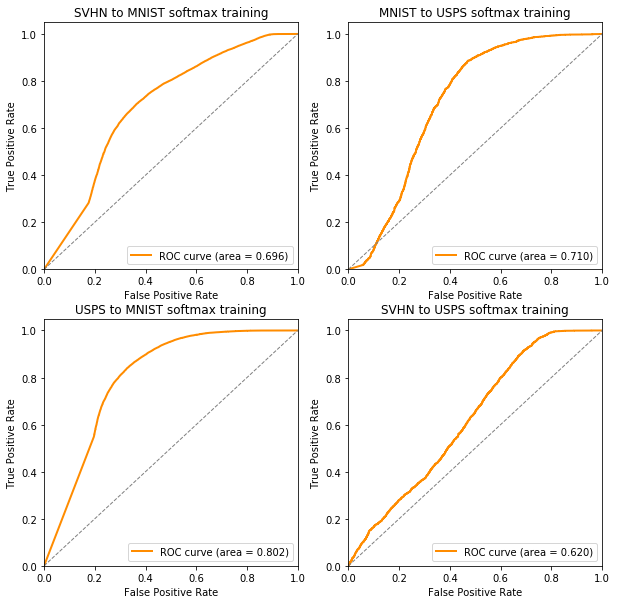

In [66]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
fpr, tpr, _ = roc_curve(y_tgt1, -minst_usps)
plot_auc_curve(fpr, tpr, ax[0,1])
ax[0,1].set_title('MNIST to USPS softmax training')
fpr, tpr, _ = roc_curve(y_tgt2, -svhn_mnist)
plot_auc_curve(fpr, tpr, ax[0,0])
ax[0,0].set_title('SVHN to MNIST softmax training')
fpr, tpr, _ = roc_curve(y_tgt3, -usps_mnist)
plot_auc_curve(fpr, tpr, ax[1,0])
ax[1,0].set_title('USPS to MNIST softmax training')
fpr, tpr, _ = roc_curve(y_tgt4, -svhn_usps)
plot_auc_curve(fpr, tpr, ax[1,1])
ax[1,1].set_title('SVHN to USPS softmax training')

new dataset